In [1]:
# Load packages
import sys
import os
import glob

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

from scipy import interpolate
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy import stats 
from scipy.optimize import curve_fit 

import FunctionsP6 as fc

import sklearn
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import dask.config as dc
dc.set(**{'array.slicing.split_large_chunks': True});

import warnings
warnings.filterwarnings('ignore')

dpi=200

In [2]:
savepath = os.getcwd()+'/Figures_M2/'

In [3]:
'''
We load the data that is prepared in 'M2_DataPrep'
'''
# GSAT, zostoga observations (1900 - 2005) merged with AR6 ranges for all scenarios (2005 - 2100) 
df_low = pd.read_csv(os.getcwd() + '/data_processed/AR6_obs17_low_perc.csv').set_index('Date')
df_mid = pd.read_csv(os.getcwd() + '/data_processed/AR6_obs17_mid_perc.csv').set_index('Date')
df_hig = pd.read_csv(os.getcwd() + '/data_processed/AR6_obs17_hig_perc.csv').set_index('Date')

# CMIP5 and CMIP6 data (1900 - 2100)
CMIP5ds = xr.open_mfdataset(os.getcwd()+'/data_processed/ds_CMIP5.nc')
CMIP6ds = xr.open_mfdataset(os.getcwd()+'/data_processed/ds_CMIP6.nc')

# DSL budgets / reanalysis (ora20c)
df_dsl_b1 = pd.read_csv(os.getcwd() + '/data_processed/DSL_b1.csv' ).set_index('time') # (1979 - 2018)
df_dsl_b2 = pd.read_csv(os.getcwd() + '/data_processed/DSL_b2.csv' ).set_index('time') # (1950 - 2020)

# Reanalysis (1905 - 2005) (1990-1994 and 2006-2009 is nan)
ds_dsl_ora20c = xr.open_mfdataset(os.getcwd()+'/data_processed/DSL_ora20c.nc') # 1900 - 2009

In [4]:
# Change ref - OPTIONAL
ref_st, ref_end = 1900,1950

for dfs in [df_low, df_mid, df_hig]:
    dfs.iloc[:,0:3] = dfs.iloc[:,0:3] - dfs.loc[ref_st:ref_end].mean()[1]
    dfs.iloc[:,3:6] = dfs.iloc[:,3:6] - dfs.loc[ref_st:ref_end].mean()[4]
#df_low = df_low - df_low.loc[ref_st:ref_end-1].mean()
#df_mid = df_mid - df_mid.loc[ref_st:ref_end-1].mean()
#df_hig = df_hig - df_hig.loc[ref_st:ref_end-1].mean()

CMIP5ds = CMIP5ds - CMIP5ds.sel(time=slice(ref_st,ref_end)).mean(dim='time')
CMIP6ds = CMIP6ds - CMIP6ds.sel(time=slice(ref_st,ref_end)).mean(dim='time')

ds_dsl_ora20c = ds_dsl_ora20c-np.nanmean(ds_dsl_ora20c.sel(year=slice(ref_st,ref_end)).median(dim='member').zos.values)#mean(dim='year')

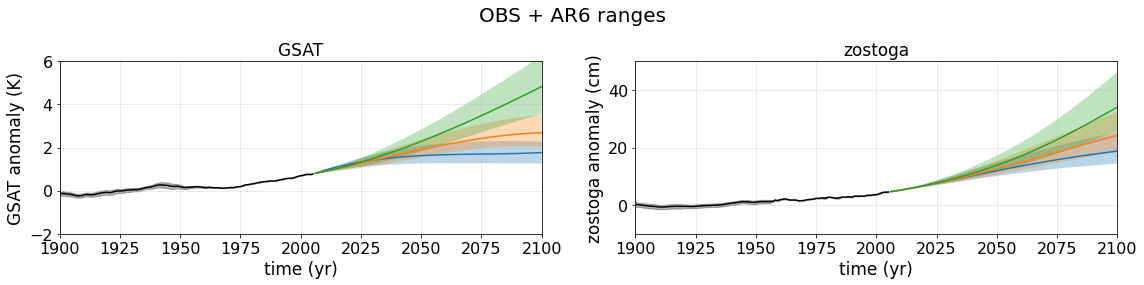

In [6]:
'''
This cell plots the Observations and AR6 ranges which we use as input for our model
'''

fig, ax = plt.subplots(1,2,figsize=(16,4))
fig.suptitle('OBS + AR6 ranges',fontsize=20) # or plt.suptitle('Main title')

# Plot observations
ax[0].plot(df_low['G_50th'].loc[1900:2005],c='k')
ax[0].fill_between(df_low.loc[1900:2005].index,df_low['G_5th'].loc[1900:2005],
                   df_low['G_95th'].loc[1900:2005],color='k',alpha=0.3)
ax[1].plot(df_low['z_50th'].loc[1900:2005],c='k')
ax[1].fill_between(df_low.loc[1900:2005].index,df_low['z_5th'].loc[1900:2005],
                   df_low['z_95th'].loc[1900:2005],color='k',alpha=0.3)
    
# Plot projections, loop over scenarios 
i = 0
for dfs in [df_low.loc[2006:2100],df_mid.loc[2006:2100],df_hig.loc[2006:2100]]:
    ax[0].plot(dfs['G_50th'])
    ax[0].fill_between(dfs.index,dfs['G_5th'],dfs['G_95th'],alpha=0.3)
    ax[1].plot(dfs['z_50th'])
    ax[1].fill_between(dfs.index,dfs['z_5th'],dfs['z_95th'],alpha=0.3)
    i = i+1
    
ax[0].set_title('GSAT',size=17)
ax[0].set_xlabel('time (yr)',size=17)
ax[0].set_ylabel('GSAT anomaly (K)',size=17)

ax[0].tick_params(axis='x', labelsize= 16)
ax[0].tick_params(axis='y', labelsize= 16)
ax[0].set_xlim([1900,2100])
ax[0].set_ylim([-2,6])
ax[0].grid(True,alpha=0.3)


ax[1].set_title('zostoga',size=17)
ax[1].set_xlabel('time (yr)',size=17)
ax[1].set_ylabel('zostoga anomaly (cm)',size=17);

ax[1].tick_params(axis='x', labelsize= 16)
ax[1].tick_params(axis='y', labelsize= 16)
ax[1].set_xlim([1900,2100])
ax[1].set_ylim([-10,50]);
ax[1].grid(True,alpha=0.3);

fig.tight_layout()
#fig.savefig(savepath+'Input_AR6_ranges.png',dpi=200)


# Multi-linear fit to data

In [7]:
def select_models(ds, varx1, varx2, vary, check):
    '''
    Check is either 'model', or 'scenario'
    Find models for which all three variables (zos, gsat, zostoga) are available
    Input is dataset CMIP5ds or CMIP6ds. 
    If you want to check the scenarios per model, already select the model in the input: eg. CMIP5ds.sel(model=mod)
    It returns the model/sce names of models/sces that have data for all three variables and returns the new dataset.
    '''
    
    x1 = ds[varx1].dropna(check,'all')[check].values
    x2 = ds[varx2].dropna(check,'all')[check].values
    y = ds[vary].dropna(check,'all')[check].values
        
    check_list = np.sort(list(set(x1)&set(x2)&set(y)))
    
    if check == 'model':
        ds_new = ds.sel(model=check_list)
        
    elif check == 'scenario':
        ds_new = ds.sel(scenario=check_list)
    
    return check_list, ds_new

In [8]:
#%% Multi-linear regression
def lin_reg_multi(varx, vary):
    regr = linear_model.LinearRegression()

    varx = varx.dropna()
    vary = vary.dropna()

    regr.fit(varx, vary)
    
    vary_pred = regr.predict(varx)

    mse = mean_squared_error(vary, vary_pred)
    r2 = r2_score(vary, vary_pred)
    slope = regr.coef_
    intercept = regr.intercept_
    
    return vary_pred, mse, r2, slope, intercept

In [9]:
def multi_lin_fit(ds):
    
    ds_new = select_models(ds, 'GSAT','zostoga','zos','model')[1]
    
    nan_array_sce = np.ones(95)*np.nan
    mods, sces = [],[]
    dfs = []
    mses, r2s, slope_varx1, slope_varx2, intercepts = [],[],[],[],[]
    
    for j, mod in enumerate(ds_new.model.values):
        sces_in_mod = select_models(ds_new.sel(model=mod), 'GSAT', 'zostoga', 'zos', 'scenario')[0]
        ds_mod = ds_new.sel(model=mod)
        mods.append(mod)           # append model name
        sces.append(sces_in_mod)   # append scenarios available for this model
        
        ds_hist = ds_mod.sel(time=slice(1900,2005),scenario=sces_in_mod[0])  # select historical period for one sce
        ds_sces = ds_mod.sel(time=slice(2005,2100))                          # select future period for all sces

        DSL_mod, GSAT_mod, zostoga_mod = ds_hist.zos.values, ds_hist.GSAT.values, ds_hist.zostoga.values        
        
            
        for sce in ['ssp126','ssp245','ssp585']:
            #ds_sces.scenario.values:
        
            ds_sce = ds_sces.sel(scenario=sce)
            
            zos = ds_sce.zos.values
            gsat = ds_sce.GSAT.values
            zostoga = ds_sce.zostoga.values
            
            if(np.isnan(zos).any()) or (np.isnan(gsat).any()) or (np.isnan(zostoga).any()):
                DSL_mod = np.append(DSL_mod, np.ones(95)*np.nan)
                GSAT_mod = np.append(GSAT_mod, np.ones(95)*np.nan)
                zostoga_mod = np.append(zostoga_mod, np.ones(95)*np.nan)
            else:
                DSL_mod = np.append(DSL_mod, ds_sce.zos.values)
                GSAT_mod = np.append(GSAT_mod, ds_sce.GSAT.values)
                zostoga_mod = np.append(zostoga_mod, ds_sce.zostoga.values)
            
        # Store total data in dataframe for each model
        d = {'DSL': DSL_mod, 'GSAT': GSAT_mod, 'zostoga': zostoga_mod}
        df = pd.DataFrame(data=d)    
        dfs.append(df)
         
        # Compute regression for this model    
        X = df[['GSAT','zostoga']] 
        Y = df[['DSL']] 
        
        #print(df)
        linreg = lin_reg_multi(X,Y)
        mse, r2, slope, intercept = linreg[1], linreg[2], linreg[3], linreg[4]
        
        mses.append(mse)
        r2s.append(r2)
        slope_varx1.append(slope[0][0])
        slope_varx2.append(slope[0][1])
        intercepts.append(intercept[0])
    
        
    # Construct dataframe to store parameter values
    d = {'model': mods, 'sces':sces, 'r2-score':r2s,'alpha': intercepts, 'beta':slope_varx1, 'gamma': slope_varx2, 'mse': mses}
    df_params = pd.DataFrame(data=d).set_index('model')
    
            
    return dfs, mods, sces, df_params

In [10]:
CMIP5_data, mods5, sces5, CMIP5_params = multi_lin_fit(CMIP5ds)
CMIP6_data, mods6, sces6, CMIP6_params = multi_lin_fit(CMIP6ds)

In [11]:
print(f'Available models for CMIP5: {len(CMIP5_params)}')
print(f'Available models for CMIP6: {len(CMIP6_params)}')

Available models for CMIP5: 23
Available models for CMIP6: 20


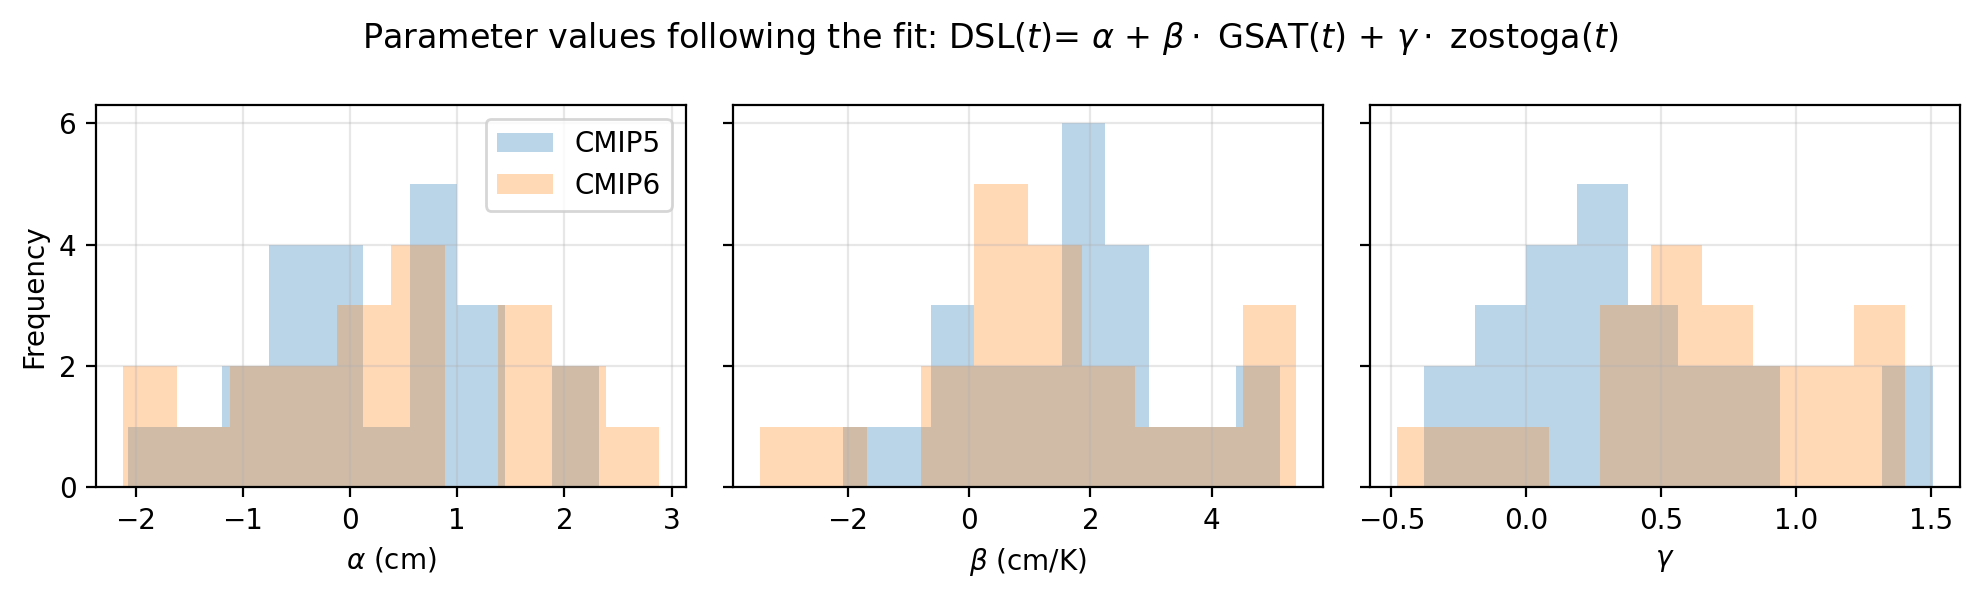

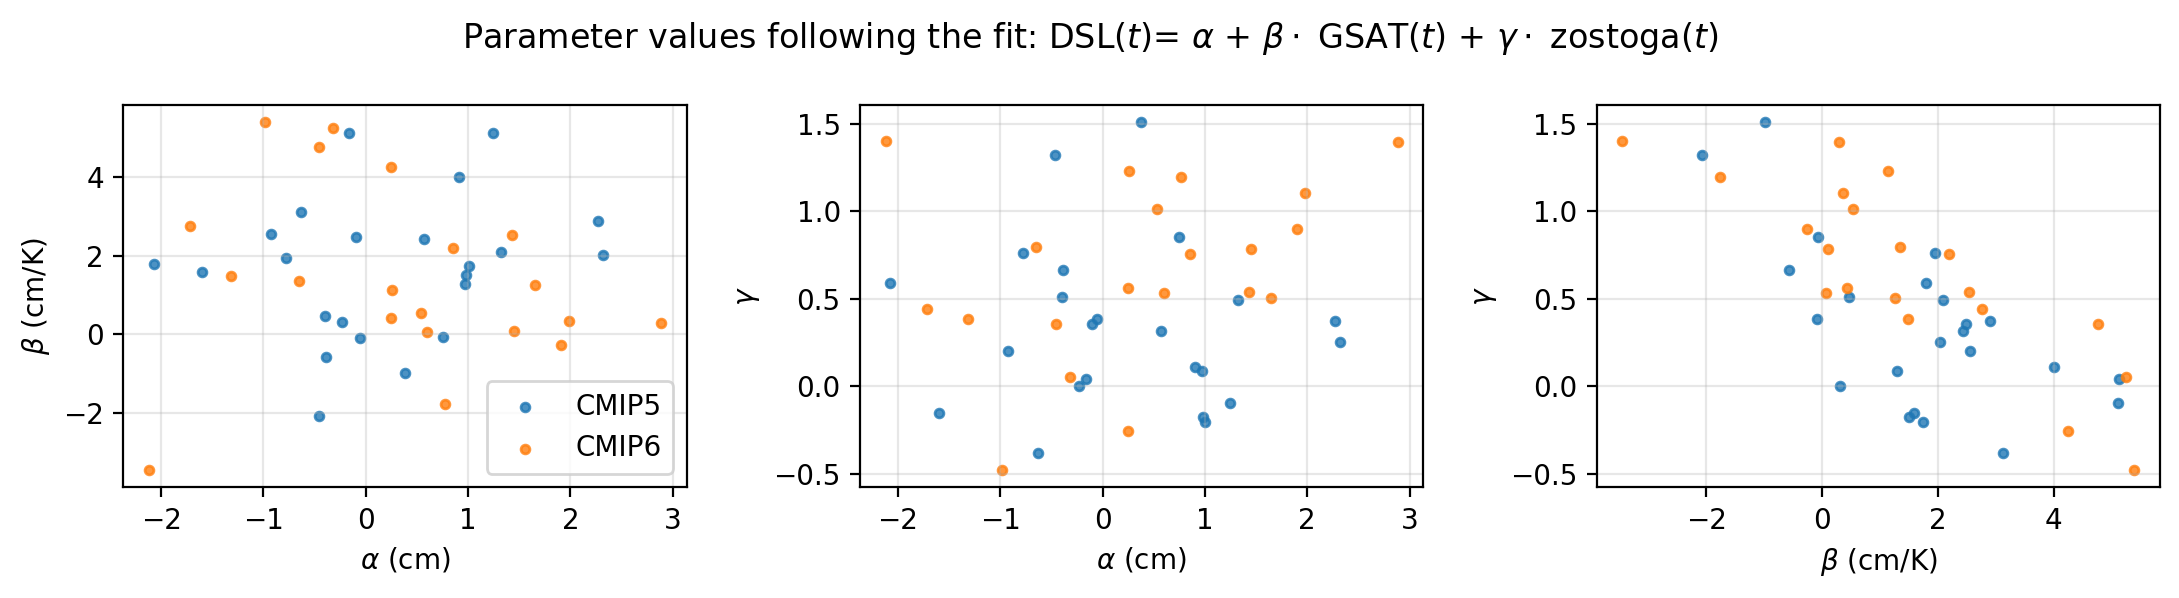

In [12]:
labs = ['CMIP5','CMIP6']

# Frequency Histogram parameter values
fig, ax = plt.subplots(1,3,figsize=(10,3),sharey=True,dpi=200)
fig.subplots_adjust(wspace=1/9)

nbins=10

for i, pars in enumerate([CMIP5_params, CMIP6_params]):
    ax[0].hist(pars['alpha'],nbins,alpha=0.3,label=labs[i])
    ax[1].hist(pars['beta'],nbins,alpha=0.3,label=labs[i])
    ax[2].hist(pars['gamma'],nbins,alpha=0.3,label=labs[i])
    
ax[0].set_xlabel(r'$\alpha$ (cm)')
ax[0].set_ylabel('Frequency')
ax[0].legend()
ax[1].set_xlabel(r'$\beta$ (cm/K)')
ax[2].set_xlabel(r'$\gamma$')

for axs in ax:
    axs.grid(True,alpha=0.3)

fig.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
fig.suptitle(r'Parameter values following the fit: DSL$(t)$= $\alpha$ + $\beta \cdot$ GSAT$(t)$ + $\gamma \cdot$ zostoga$(t)$', fontsize=12)
fig.tight_layout()
#fig.savefig(savepath+f'Params_hist',dpi=250)


# Scatter plot parameter values
fig, ax = plt.subplots(1,3,figsize=(11,3), dpi=200)
#fig.subplots_adjust(wspace=.1)

for i, pars in enumerate([CMIP5_params, CMIP6_params]):
    ax[0].scatter(pars['alpha'], pars['beta'], nbins,alpha=0.8,label=labs[i])
    ax[1].scatter(pars['alpha'], pars['gamma'], nbins,alpha=0.8,label=labs[i])
    ax[2].scatter(pars['beta'], pars['gamma'], nbins,alpha=0.8,label=labs[i])

ax[0].legend()
ax[0].set_xlabel(r'$\alpha$ (cm)')
ax[0].set_ylabel(r'$\beta$ (cm/K)')
ax[1].set_xlabel(r'$\alpha$ (cm)')
ax[1].set_ylabel(r'$\gamma$')
ax[2].set_xlabel(r'$\beta$ (cm/K)')
ax[2].set_ylabel(r'$\gamma$')

for axs in ax:
    axs.grid(True,alpha=0.3)

fig.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
fig.suptitle(r'Parameter values following the fit: DSL$(t)$= $\alpha$ + $\beta \cdot$ GSAT$(t)$ + $\gamma \cdot$ zostoga$(t)$', fontsize=12);
fig.tight_layout()
#fig.savefig(savepath+f'Params_scat',dpi=250) 

In [34]:
#=========================================================
#%% Function to plot individual models DSL and fits
#=========================================================
def checks_3(df, params, mip, mod_list, sce_list):
    
    # INDIVIDUAL MODELS
    rows = np.round(len(mod_list)/4+.499)
    
    fig, ax = plt.subplots(int(rows),4,figsize=(24,24),sharex=True,sharey=True)
    fig.suptitle(f'{mip}', fontsize=20)
    fig.subplots_adjust(hspace = 0.5, wspace=0.2)

    ax = ax.ravel()
    
    m_DSLs, DSL_fits = [],[]
    alphs, bets, gams = [],[],[]
    
    for i in range(int(len(mod_list))):
        df_mod, sces_mod, mod_name = df[i], sce_list[i], mod_list[i]
        pars = params.loc[mod_name]
        
        DSL_fit = pars['alpha'] + pars['beta']*df_mod['GSAT']+ pars['gamma']*df_mod['zostoga']
        
        nan_index = np.argwhere(np.isnan(DSL_fit.values))
        alph = np.ones([len(df_mod['GSAT'])])*pars['alpha']
        alph[nan_index] = np.nan # fix this that alpha is NaN for scenario with no data
        
        bet = pars['beta']*df_mod['GSAT']
        gam = pars['gamma']*df_mod['zostoga']
        r2 = pars['r2-score']
        mse = pars['mse']
        
        m_DSLs.append(df_mod['DSL'])
        DSL_fits.append(DSL_fit)
        alphs.append(alph)
        bets.append(bet)
        gams.append(gam)
        
        # Plot composition for each model separately
        ax[i].plot(df_mod['DSL'], label='Data')
        ax[i].plot(DSL_fit, c='r',label='Regression Model')
        ax[i].plot(alph, c='g',label=r'$\alpha$')
        ax[i].plot(bet, c='k',label=r'$\beta \times$ GSAT')
        ax[i].plot(gam, c='orange',label=r'$\gamma \times$ zostoga')
        
        ax[i].tick_params(axis='x', labelsize=15)
        ax[i].tick_params(axis='y', labelsize=15)
        ax[i].set_xlabel('Time', fontsize=15)
        if i % 4 == 0:
            ax[i].set_ylabel('DSL anomaly (cm)', fontsize = 15)
        
        ax[i].tick_params(axis='x', labelsize=12)
        ax[i].tick_params(axis='y', labelsize=15)
    
        if mip == 'CMIP5':
            ax[i].set_xticks([0, 105, 200,295], ["Historic", "RCP2.6", "RCP4.5",'RCP8.5'],  horizontalalignment='left')
        elif mip == 'CMIP6':
            ax[i].set_xticks([0, 105, 200,295], ["Historic", "SSP1-2.6", "SSP2-4.5",'SSP5-8.5'],  horizontalalignment='left')

        
        ax[i].set_ylim([-10,50])
        ax[i].set_title(f'Model: {mod_name} \n R2-score: {r2:.2f}, RMS: {mse:.2f} cm', fontsize=16)
        #\n Sces: {sces_mod}
        ax[i].grid(True, alpha=0.3)
        
        if i == 0:
            ax[i].legend()

    #fig.savefig(savepath+f'Regression_{mip}_individualmodels',dpi=250)
    
    
    # ENSEMBLE AVERAGE
    fig, ax = plt.subplots(1,1,figsize=(12,8))
    ax.plot(np.nanmean(m_DSLs,axis=0),label='Data')
    ax.plot(np.nanmean(DSL_fits,axis=0),c='r',label='Regression Model')
    ax.plot(np.nanmean(alphs,axis=0), c='g',label=r'$\alpha$')
    ax.plot(np.nanmean(bets,axis=0), c='k',label=r'$\beta \times$ GSAT')
    ax.plot(np.nanmean(gams,axis=0),c='orange',label=r'$\gamma \times$ zostoga')

    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=15)
    
    if mip == 'CMIP5':
        ax.set_xticks([0, 105, 200,295], ["Historic (1900 - 2005)", "RCP2.6 (2005 - 2100)", "RCP4.5 (2005 - 2100)",'RCP8.5 (2005 - 2100)'],  horizontalalignment='left')
    elif mip == 'CMIP6':
        ax.set_xticks([0, 105, 200,295], ["Historic (1900 - 2005)", "SSP1-2.6 (2005 - 2100)", "SSP2-4.5(2005 - 2100)",'SSP5-8.5 (2005 - 2100)'],  horizontalalignment='left')

    ax.set_xlabel('Time', fontsize=15)
    ax.set_ylabel('DSL anomaly (cm)', fontsize = 15)
    ax.set_xlim([0,390])
    ax.set_ylim([-10,50])
    ax.axvspan(0, 50, alpha=0.1, color='grey')

    ax.set_title(f'Ensemble Average - {mip}', fontsize=16)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper left',fontsize=12)
    
    fig.savefig(savepath+f'Regression_{mip}_mean',dpi=300)

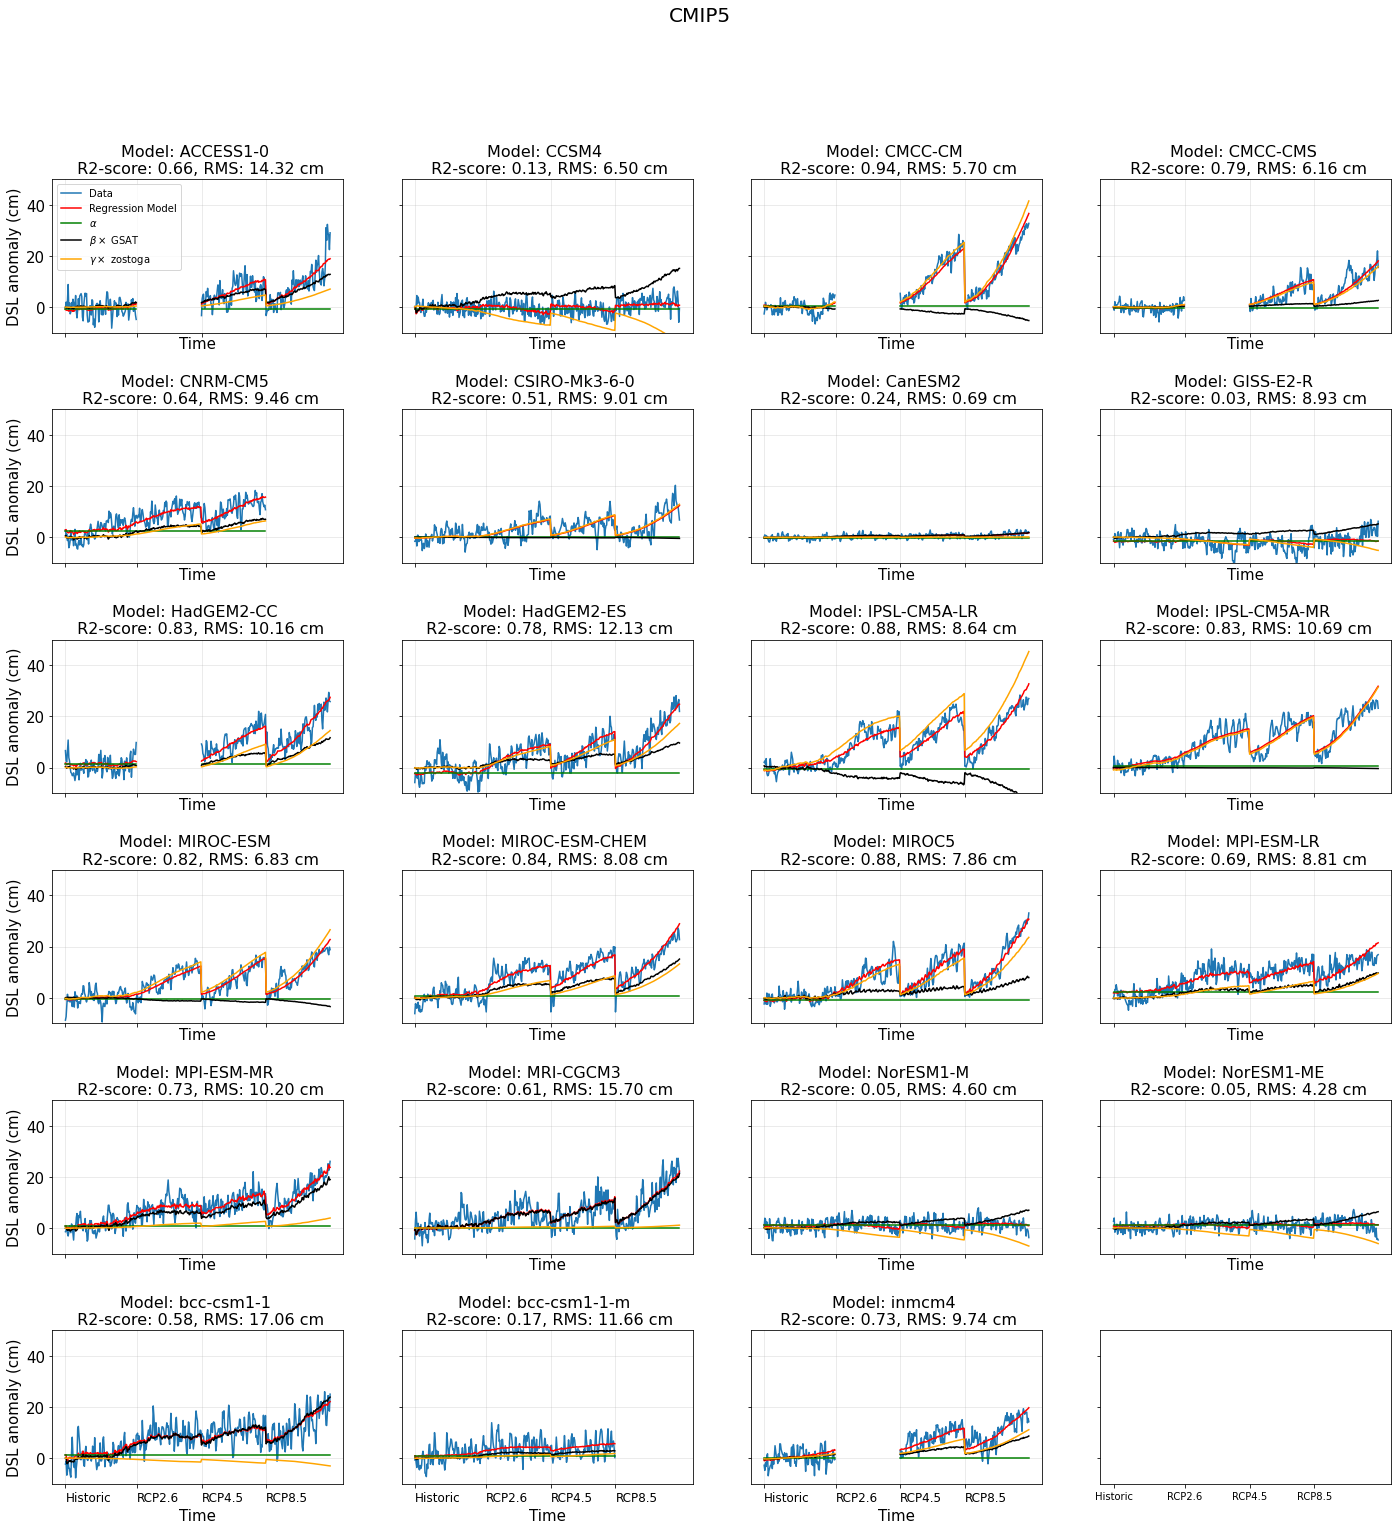

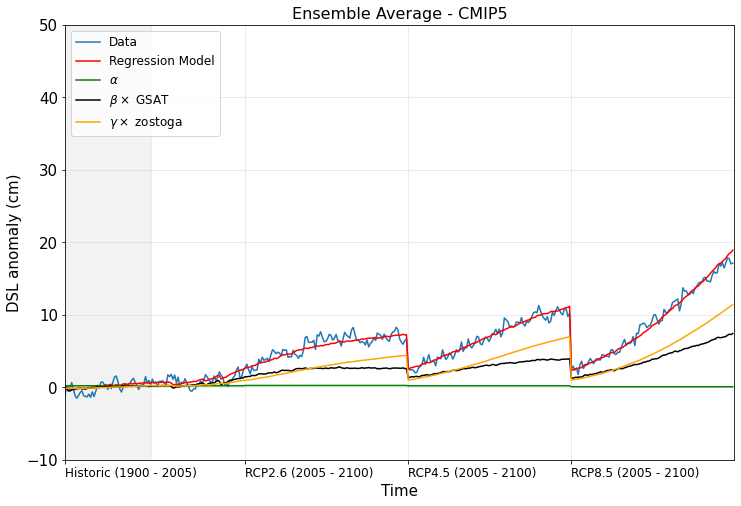

In [35]:
checks_3(CMIP5_data, CMIP5_params, 'CMIP5', mods5, sces5)

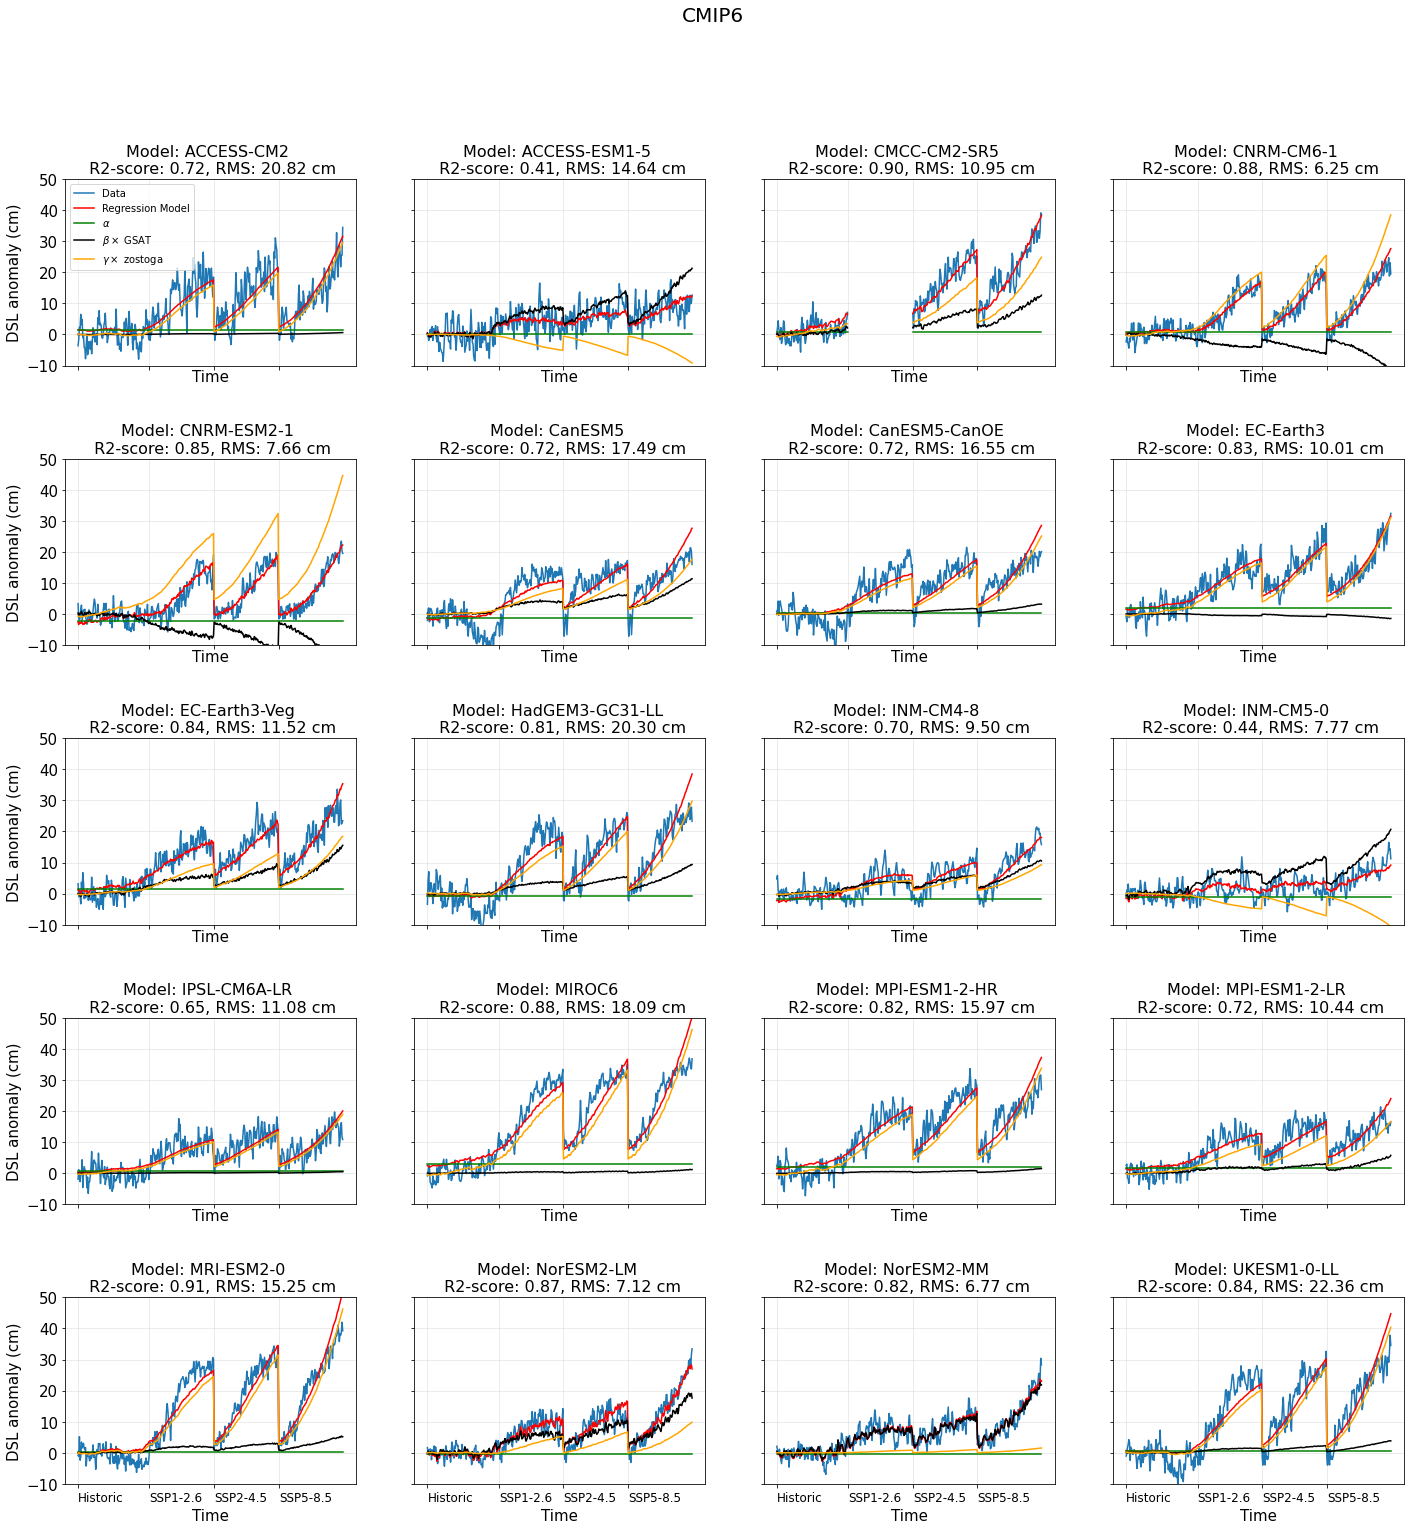

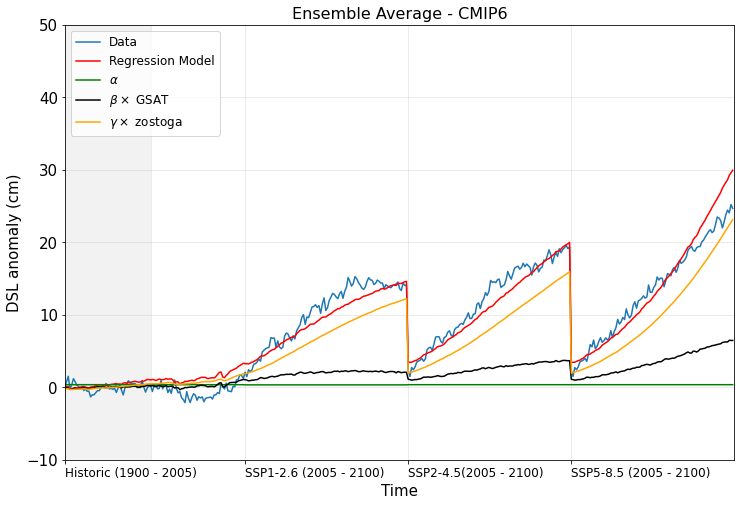

In [36]:
checks_3(CMIP6_data, CMIP6_params, 'CMIP6', mods6, sces6)

In [45]:
def compute_distr_ensembles(ds, sce):
    '''
    Function that computes percentiles for GSAT and zostoga from model data
    '''
    
    mods = select_models(ds.sel(scenario=sce), 'GSAT','zostoga','zos','model')[0]
    time = np.arange(1900,2100,1)
    ds = ds.sel(time=slice(1900,2100),scenario=sce, model=mods)
    print(ds.model.values)
    GSATs = ds.GSAT.values
    zosts = ds.zostoga.values
    
    g_5, g_50, g_95 = [],[],[]
    z_5, z_50, z_95 = [],[],[]
    
    for i in range(len(GSATs[0])):
        g_5.append(np.quantile(GSATs[:,i],0.05))
        g_50.append(np.quantile(GSATs[:,i],0.5))
        g_95.append(np.quantile(GSATs[:,i],0.95))
        z_5.append(np.quantile(zosts[:,i],0.05))
        z_50.append(np.quantile(zosts[:,i],0.5))
        z_95.append(np.quantile(zosts[:,i],0.95))
        
    d = {'Date': time, 'G_5th': g_5, 'G_50th': g_50, 'G_95th': g_95,'z_5th': z_5, 'z_50th': z_50, 'z_95th': z_95}
    df = pd.DataFrame(data=d)
    df = df.set_index('Date')
    
    return df

def func(x, a, scale):
    func_cdf = stats.lognorm
    iloc = -10

    return func_cdf.cdf(x, a, iloc, scale)

def range_to_dist(df, var, n, st_yr, end_yr):
    '''
    INPUT:
        - df: dataframe as above
        - var: either 'GSAT' or 'zostoga'
        - pc: percentiles: ea [5, 50, 95]
        - n: number of samples you want to generate
    OUTPUT:
        - random distribution with n values
    '''
    distrs = []
    func_cdf = stats.lognorm

    for i in range(st_yr,end_yr+1):
        yr = i
        
        if var == 'GSAT':
            data_sel = df.loc[yr][0:3]
            pc = np.array([5,50,95])*0.01
            
        elif var == 'zostoga':
            data_sel = df.loc[yr][3:6]
            pc = np.array([5,50,95])*0.01

        iloc = -10
        popt, pcov = curve_fit(func, data_sel, pc)
        err = np.square(func(data_sel.astype(float), popt[0], popt[1]) - pc).mean()
    
        # Calculate mean and std for probability function
        mean = func_cdf.mean(popt[0], iloc, popt[1])
        std = func_cdf.std(popt[0], iloc, popt[1])
        
        # Translate to mu and sigma
        mu = np.log(mean**2/np.sqrt(mean**2+std**2))
        sigma = np.sqrt(np.log(1+(std**2/mean**2)))
        
        # Sample n values from distribution and store in array
        distr = np.random.lognormal(mu, sigma, n)
        distr = np.sort(distr)
        
        # Save distribution to array
        distrs.append(distr)
        
    return distrs

In [23]:
def range_to_dist_obs(df, var, n, st_yr, end_yr):
    '''
    INPUT:
        - df: dataframe as above
        - var: either 'GSAT' or 'zostoga'
        - pc: percentiles: ea [5, 50, 95]
        - n: number of samples you want to generate
    OUTPUT:
        - random distribution with n values
    '''
    distrs = []
    func_cdf = stats.lognorm
        
    for i in range(st_yr,end_yr+1):
        yr = i
        
        if var == 'obs_GS':
            data_sel = df.loc[yr][0:3]
            pc = np.array([2.5,50,97.5])*0.01
            
        elif var == 'obs_zt':
            data_sel = df.loc[yr][3:6]
            pc = np.array([5,50,95])*0.01
        
        #print(data_sel)
        iloc = -10
        popt, pcov = curve_fit(func, data_sel, pc)
        err = np.square(func(data_sel.astype(float), popt[0], popt[1]) - pc).mean()
    
        # Calculate mean and std for probability function
        mean = func_cdf.mean(popt[0], iloc, popt[1])
        std = func_cdf.std(popt[0], iloc, popt[1])
        
        # Translate to mu and sigma
        mu = np.log(mean**2/np.sqrt(mean**2+std**2))
        sigma = np.sqrt(np.log(1+(std**2/mean**2)))
        
        # Sample n values from distribution and store in array
        distr = np.random.lognormal(mu, sigma, n)
        distr = np.sort(distr)
        
        # Save distribution to array
        distrs.append(distr)
    
    return distrs

In [24]:
n = 1000

### Distributions from AR6
# 1900 - 1960
n = 1000
G_dis_obs = range_to_dist_obs(df_low+10,'obs_GS',n, 1900, 1959) - np.array([10])
zt_dis_obs = range_to_dist_obs(df_low+10,'obs_zt',n, 1900, 1959) - np.array([10])

# 1960 - 2005
G_dis_obs_b = np.zeros([51,n])
zt_dis_obs_b = np.zeros([51,n])

for i in range(51):
    G_dis_obs_b[i] = np.ones([n])*df_low.loc[1960+i][1]
    zt_dis_obs_b[i] = np.ones([n])*df_low.loc[1960+i][4]

# 2005 - 2101
# SOMETHING GOES WRONG IN 2005!! 
st_yr, end_yr = 2011,2100
G_dis_l = range_to_dist(df_low, 'GSAT', n, st_yr, end_yr)
G_dis_m = range_to_dist(df_mid, 'GSAT', n, st_yr, end_yr)
G_dis_h = range_to_dist(df_hig, 'GSAT', n, st_yr, end_yr)
zt_dis_l = range_to_dist(df_low, 'zostoga', n, st_yr, end_yr)
zt_dis_m = range_to_dist(df_mid, 'zostoga', n, st_yr, end_yr)
zt_dis_h = range_to_dist(df_hig, 'zostoga', n, st_yr, end_yr)

#ref_range = df_obs.loc[1990:2005-1].mean()

low_GS = np.concatenate([G_dis_obs, G_dis_obs_b, G_dis_l])#-ref_range[1]
mid_GS = np.concatenate([G_dis_obs, G_dis_obs_b, G_dis_m])#-ref_range[1]
hig_GS = np.concatenate([G_dis_obs, G_dis_obs_b, G_dis_h])#-ref_range[1]

low_zt = np.concatenate([zt_dis_obs, zt_dis_obs_b, zt_dis_l])#-ref_range[4]
mid_zt = np.concatenate([zt_dis_obs, zt_dis_obs_b, zt_dis_m])#-ref_range[4]
hig_zt = np.concatenate([zt_dis_obs, zt_dis_obs_b, zt_dis_h])#-ref_range[4]

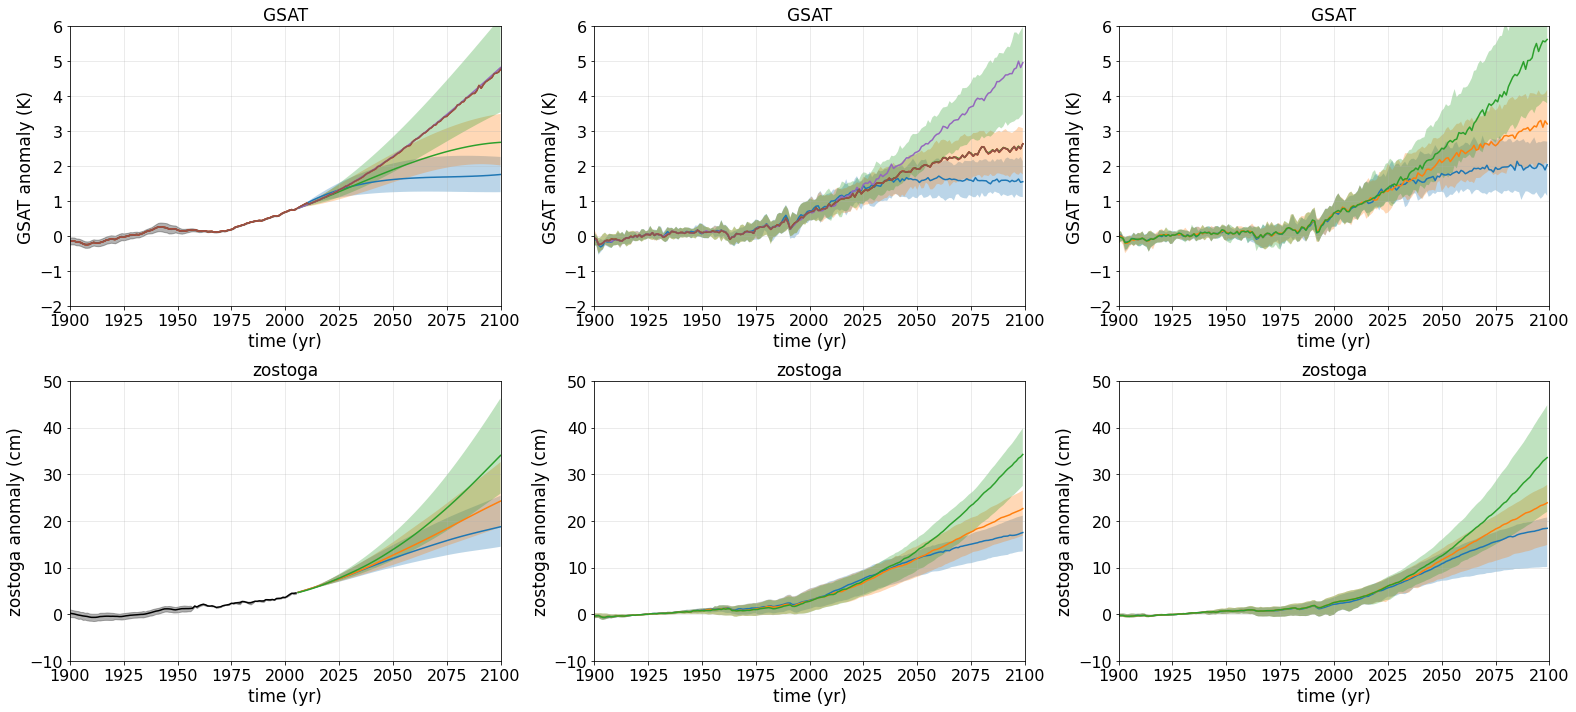

In [27]:

'''
This cell plots the Observations and AR6 ranges which we use as input for our model
'''

df_cm5_low = compute_distr_ensembles(CMIP5ds, 'ssp126')
df_cm5_mid = compute_distr_ensembles(CMIP5ds, 'ssp245')
df_cm5_hig = compute_distr_ensembles(CMIP5ds, 'ssp585')

df_cm6_low = compute_distr_ensembles(CMIP6ds, 'ssp126')
df_cm6_mid = compute_distr_ensembles(CMIP6ds, 'ssp245')
df_cm6_hig = compute_distr_ensembles(CMIP6ds, 'ssp585')


fig, ax = plt.subplots(nrows=2,ncols =3,figsize=(22,10))
#fig.suptitle('OBS + AR6 ranges',fontsize=20) # or plt.suptitle('Main title')


# Plot projections, loop over scenarios 

ax[0,0].plot(df_low['G_50th'].loc[1900:2005],c='k')
ax[0,0].fill_between(df_low.loc[1900:2005].index,df_low['G_5th'].loc[1900:2005],
                   df_low['G_95th'].loc[1900:2005],color='k',alpha=0.3)
ax[1,0].plot(df_low['z_50th'].loc[1900:2005],c='k')
ax[1,0].fill_between(df_low.loc[1900:2005].index,df_low['z_5th'].loc[1900:2005],
                   df_low['z_95th'].loc[1900:2005],color='k',alpha=0.3)
    
for dfs in [df_low.loc[2006:2100],df_mid.loc[2006:2100],df_hig.loc[2006:2100]]:
    ax[0,0].plot(dfs['G_50th'])
    ax[0,0].fill_between(dfs.index,dfs['G_5th'],dfs['G_95th'],alpha=0.3)
    ax[0,0].plot(np.arange(1900,2101,1),np.median(hig_GS,axis=1))
    ax[1,0].plot(dfs['z_50th'])
    ax[1,0].fill_between(dfs.index,dfs['z_5th'],dfs['z_95th'],alpha=0.3)
    i = i+1
    
i = 0
for dfs in [df_cm5_low.loc[1900:2100],df_cm5_mid.loc[1900:2100],df_cm5_hig.loc[1900:2100]]:
    ax[0,1].plot(dfs['G_50th'])
    ax[0,1].fill_between(dfs.index,dfs['G_5th'],dfs['G_95th'],alpha=0.3)
    ax[0,1].plot(np.arange(1900,2100,1),np.median(G_dis_C5_m,axis=1))

    ax[1,1].plot(dfs['z_50th'])
    ax[1,1].fill_between(dfs.index,dfs['z_5th'],dfs['z_95th'],alpha=0.3)
    i = i+1

for dfs in [df_cm6_low.loc[1900:2100],df_cm6_mid.loc[1900:2100],df_cm6_hig.loc[1900:2100]]:
    ax[0,2].plot(dfs['G_50th'])
    ax[0,2].fill_between(dfs.index,dfs['G_5th'],dfs['G_95th'],alpha=0.3)
    ax[1,2].plot(dfs['z_50th'])
    ax[1,2].fill_between(dfs.index,dfs['z_5th'],dfs['z_95th'],alpha=0.3)
    i = i+1

for i in range(3):
    ax[0,i].set_title('GSAT',size=17)
    ax[0,i].set_xlabel('time (yr)',size=17)
    ax[0,i].set_ylabel('GSAT anomaly (K)',size=17)

    ax[0,i].tick_params(axis='x', labelsize= 16)
    ax[0,i].tick_params(axis='y', labelsize= 16)
    ax[0,i].set_xlim([1900,2100])
    ax[0,i].set_ylim([-2,6])
    ax[0,i].grid(True,alpha=0.3)


    ax[1,i].set_title('zostoga',size=17)
    ax[1,i].set_xlabel('time (yr)',size=17)
    ax[1,i].set_ylabel('zostoga anomaly (cm)',size=17);

    ax[1,i].tick_params(axis='x', labelsize= 16)
    ax[1,i].tick_params(axis='y', labelsize= 16)
    ax[1,i].set_xlim([1900,2100])
    ax[1,i].set_ylim([-10,50]);
    ax[1,i].grid(True,alpha=0.3);

cols = ['Column {}'.format(col) for col in range(1, 3)]


    
fig.tight_layout()
#fig.savefig(savepath+'Input_GSAT_zt.png',dpi=300)


13.278115705433558
15.603574500712112
18.087075752316395


(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  4.,  1.,  3.,  5.,  4.,
         4.,  2.,  6.,  4.,  2.,  9., 12., 11.,  7., 16., 18., 11., 19.,
        13., 19., 19., 13., 18., 27., 21., 18., 27., 34., 26., 25., 27.,
        25., 34., 27., 27., 26., 21., 23., 27., 23., 26., 33., 26., 22.,
        24., 15., 22., 13., 17., 15., 17., 19.,  8.,  5., 10.,  6.,  9.,
         3.,  6.,  6.,  5.,  3.,  7.,  0.,  5.,  4.,  2.,  3.,  0.,  2.,
         0.,  0.,  0.,  2.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([11.27359156, 11.37809832, 11.48260508, 11.58711184, 11.6916186 ,
        11.79612536, 11.90063212, 12.00513888, 12.10964564, 12.2141524 ,
        12.31865916, 12.42316592, 12.52767268, 12.63217944, 12.7366862 ,
        12.84119296, 12.94569972, 13.05020648, 13.15471324, 13.25922   ,
        13.36372676, 13.46823352, 13.57274028, 13.67724704, 13.7817538 ,
        13.88626056, 13.99076732, 14.09527408, 14.19978084, 14.304287

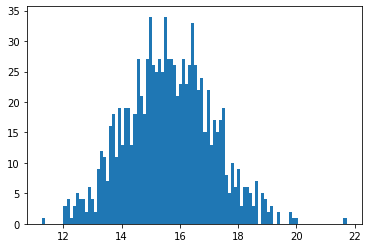

In [44]:
print(np.percentile(z_dis_C5_l[180],5))
print(np.percentile(z_dis_C5_l[180],50))

print(np.percentile(z_dis_C5_l[180],95))

plt.hist(z_dis_C5_l[180],100)

In [46]:
####### direct CMIP input

st_yr, end_yr = 1900,2099
G_dis_C5_l = range_to_dist(compute_distr_ensembles(CMIP5ds, 'ssp126')+10, 'GSAT', n, st_yr, end_yr)- np.array([10])
G_dis_C5_m = range_to_dist(compute_distr_ensembles(CMIP5ds, 'ssp245')+10, 'GSAT', n, st_yr, end_yr)- np.array([10])
G_dis_C5_h = range_to_dist(compute_distr_ensembles(CMIP5ds, 'ssp585')+10, 'GSAT', n, st_yr, end_yr)- np.array([10])

z_dis_C5_l = range_to_dist(compute_distr_ensembles(CMIP5ds, 'ssp126')+10, 'zostoga', n, st_yr, end_yr)- np.array([10])
z_dis_C5_m = range_to_dist(compute_distr_ensembles(CMIP5ds, 'ssp245')+10, 'zostoga', n, st_yr, end_yr)- np.array([10])
z_dis_C5_h = range_to_dist(compute_distr_ensembles(CMIP5ds, 'ssp585')+10, 'zostoga', n, st_yr, end_yr)- np.array([10])


G_dis_C6_l = range_to_dist(compute_distr_ensembles(CMIP6ds, 'ssp126')+10, 'GSAT', n, st_yr, end_yr)- np.array([10])
G_dis_C6_m = range_to_dist(compute_distr_ensembles(CMIP6ds, 'ssp245')+10, 'GSAT', n, st_yr, end_yr)- np.array([10])
G_dis_C6_h = range_to_dist(compute_distr_ensembles(CMIP6ds, 'ssp585')+10, 'GSAT', n, st_yr, end_yr)- np.array([10])

z_dis_C6_l = range_to_dist(compute_distr_ensembles(CMIP6ds, 'ssp126')+10, 'zostoga', n, st_yr, end_yr)- np.array([10])
z_dis_C6_m = range_to_dist(compute_distr_ensembles(CMIP6ds, 'ssp245')+10, 'zostoga', n, st_yr, end_yr)- np.array([10])
z_dis_C6_h = range_to_dist(compute_distr_ensembles(CMIP6ds, 'ssp585')+10, 'zostoga', n, st_yr, end_yr)- np.array([10])


['CCSM4' 'CNRM-CM5' 'CSIRO-Mk3-6-0' 'CanESM2' 'GISS-E2-R' 'HadGEM2-ES'
 'IPSL-CM5A-LR' 'IPSL-CM5A-MR' 'MIROC-ESM' 'MIROC-ESM-CHEM' 'MIROC5'
 'MPI-ESM-LR' 'MPI-ESM-MR' 'MRI-CGCM3' 'NorESM1-M' 'NorESM1-ME'
 'bcc-csm1-1' 'bcc-csm1-1-m']
['ACCESS1-0' 'CCSM4' 'CMCC-CM' 'CMCC-CMS' 'CNRM-CM5' 'CSIRO-Mk3-6-0'
 'CanESM2' 'GISS-E2-R' 'HadGEM2-CC' 'HadGEM2-ES' 'IPSL-CM5A-LR'
 'IPSL-CM5A-MR' 'MIROC-ESM' 'MIROC-ESM-CHEM' 'MIROC5' 'MPI-ESM-LR'
 'MPI-ESM-MR' 'MRI-CGCM3' 'NorESM1-M' 'NorESM1-ME' 'bcc-csm1-1'
 'bcc-csm1-1-m' 'inmcm4']
['ACCESS1-0' 'CCSM4' 'CMCC-CM' 'CMCC-CMS' 'CSIRO-Mk3-6-0' 'CanESM2'
 'GISS-E2-R' 'HadGEM2-CC' 'HadGEM2-ES' 'IPSL-CM5A-LR' 'IPSL-CM5A-MR'
 'MIROC-ESM' 'MIROC-ESM-CHEM' 'MIROC5' 'MPI-ESM-LR' 'MPI-ESM-MR'
 'MRI-CGCM3' 'NorESM1-M' 'NorESM1-ME' 'bcc-csm1-1' 'inmcm4']
['CCSM4' 'CNRM-CM5' 'CSIRO-Mk3-6-0' 'CanESM2' 'GISS-E2-R' 'HadGEM2-ES'
 'IPSL-CM5A-LR' 'IPSL-CM5A-MR' 'MIROC-ESM' 'MIROC-ESM-CHEM' 'MIROC5'
 'MPI-ESM-LR' 'MPI-ESM-MR' 'MRI-CGCM3' 'NorESM1-M' 'NorESM1-ME'
 'bcc-csm

In [26]:
m5_26 = select_models(CMIP5ds.sel(scenario='ssp126'), 'GSAT','zostoga','zos','model')[0]
m5_45 = select_models(CMIP5ds.sel(scenario='ssp245'), 'GSAT','zostoga','zos','model')[0]
m5_85 = select_models(CMIP5ds.sel(scenario='ssp585'), 'GSAT','zostoga','zos','model')[0]
m6_26 = select_models(CMIP6ds.sel(scenario='ssp126'), 'GSAT','zostoga','zos','model')[0]
m6_45 = select_models(CMIP6ds.sel(scenario='ssp245'), 'GSAT','zostoga','zos','model')[0]
m6_85 = select_models(CMIP6ds.sel(scenario='ssp585'), 'GSAT','zostoga','zos','model')[0]

pars_CMIP5_sce26 = CMIP5_params.loc[m5_26]
pars_CMIP5_sce45 = CMIP5_params.loc[m5_45]
pars_CMIP5_sce85 = CMIP5_params.loc[m5_85]

pars_CMIP6_sce26 = CMIP6_params.loc[m6_26]
pars_CMIP6_sce45 = CMIP6_params.loc[m6_45]
pars_CMIP6_sce85 = CMIP6_params.loc[m6_85]

CMIP5_parameters = [pars_CMIP5_sce26, pars_CMIP5_sce45, pars_CMIP5_sce85]
CMIP6_parameters = [pars_CMIP6_sce26, pars_CMIP6_sce45, pars_CMIP6_sce85]

In [28]:
def compute_DSLs(mip, sce, CMIP5_params, CMIP6_params, samples, G_distrs, zt_distrs, dep):
    
    if sce == 'ssp126' or sce =='rcp26':
        sce_index = 0
    elif sce == 'ssp245' or sce =='rcp45':
        sce_index = 1
    elif sce == 'ssp585' or sce =='rcp85':
        sce_index = 2
    
    if mip == 'cmip5':
        paramsets = CMIP5_params[sce_index]
    elif mip == 'cmip6':
        paramsets = CMIP6_params[sce_index]
        
    # Create arrays in which we store random_params and 
    random_params = np.zeros([samples,3])
    DSL = np.zeros(200)
    DSLs = np.zeros([samples,200])
    
    # Loop over the number of samples you want to take
    for j in range(0, samples):
        # Select a random set of alpha, beta, gamma, linear dependence: zostoga(GSAT) = a1 + a0 * GSAT
        random = paramsets.sample()
        random_params[j] = random['alpha'], random['beta'], random['gamma']#, random['a0'], random['a1']

        dist_GS = np.random.choice(np.arange(0,len(G_distrs[0])))

        if dep == 'complete':
            dist_zt = dist_GS

            for i in range(0,200):
                GSAT_val, zt_val = G_distrs[i][dist_GS], zt_distrs[i][dist_zt]
                DSL[i] = random_params[j][0] + GSAT_val * random_params[j][1] + zt_val * random_params[j][2]
            
        elif dep == 'none':
            dist_zt = np.random.choice(np.arange(0,len(zt_distrs[0])))

            for i in range(0,200):
                GSAT_val, zt_val = G_distrs[i][dist_GS], zt_distrs[i][dist_zt]
                DSL[i] = random_params[j][0] + GSAT_val * random_params[j][1] + zt_val * random_params[j][2]
            
        elif dep == 'linear':
            for i in range(0,200):
                GSAT_val = G_distrs[i][dist_GS]
                zt_val = random_params[j][4] + random_params[j][3] * GSAT_val
                DSL[i] = random_params[j][0] + GSAT_val * random_params[j][1] + zt_val * random_params[j][2]
        # Loop over all time steps using these parameter sets and GSAT-zostoga paths, start in 2020
        DSLs[j] = DSL
    
    #print(np.median(zt_vals))
    
    return DSLs

In [29]:
# No independence - model input
n = 1000
res_c5_26_n_ext = compute_DSLs('cmip5', 'rcp26', CMIP5_parameters, CMIP6_parameters, n, G_dis_C5_l, z_dis_C5_l,'none')
res_c5_45_n_ext = compute_DSLs('cmip5', 'rcp45', CMIP5_parameters, CMIP6_parameters, n, G_dis_C5_m, z_dis_C5_m,'none')
res_c5_85_n_ext = compute_DSLs('cmip5', 'rcp85', CMIP5_parameters, CMIP6_parameters, n, G_dis_C5_h, z_dis_C5_h,'none')

res_c6_26_n_ext = compute_DSLs('cmip6', 'ssp126', CMIP5_parameters, CMIP6_parameters, n, G_dis_C6_l, z_dis_C6_l,'none')
res_c6_45_n_ext = compute_DSLs('cmip6', 'ssp245', CMIP5_parameters, CMIP6_parameters, n, G_dis_C6_m, z_dis_C6_m,'none')
res_c6_85_n_ext = compute_DSLs('cmip6', 'ssp585', CMIP5_parameters, CMIP6_parameters, n, G_dis_C6_h, z_dis_C6_h,'none')

In [30]:
# No independence - AR6 input
n = 1000
res_c5_26_n_cor = compute_DSLs('cmip5', 'rcp26', CMIP5_parameters, CMIP6_parameters, n, low_GS, low_zt,'none')
res_c5_45_n_cor = compute_DSLs('cmip5', 'rcp45', CMIP5_parameters, CMIP6_parameters, n, mid_GS, mid_zt,'none')
res_c5_85_n_cor = compute_DSLs('cmip5', 'rcp85', CMIP5_parameters, CMIP6_parameters, n, hig_GS, hig_zt,'none')

res_c6_26_n_cor = compute_DSLs('cmip6', 'ssp126', CMIP5_parameters, CMIP6_parameters, n, low_GS, low_zt,'none')
res_c6_45_n_cor = compute_DSLs('cmip6', 'ssp245', CMIP5_parameters, CMIP6_parameters, n, mid_GS, mid_zt,'none')
res_c6_85_n_cor = compute_DSLs('cmip6', 'ssp585', CMIP5_parameters, CMIP6_parameters, n, hig_GS, hig_zt,'none')

In [31]:
CMIP5_DSLs_n_ext = [res_c5_26_n_ext, res_c5_45_n_ext, res_c5_85_n_ext]
CMIP6_DSLs_n_ext = [res_c6_26_n_ext, res_c6_45_n_ext, res_c6_85_n_ext]

CMIP5_DSLs_n_cor = [res_c5_26_n_cor, res_c5_45_n_cor, res_c5_85_n_cor]
CMIP6_DSLs_n_cor = [res_c6_26_n_cor, res_c6_45_n_cor, res_c6_85_n_cor]

In [32]:
def plot_Method2_differences(DSLs_direct, DSLs_corrected, dep, mip):
    fig, ax = plt.subplots(1,1,figsize=(7,3))
    yrs = np.arange(1900,2100,1)
    sces = ["*2.6", "*4.5", "*8.5"]
    
    for i in range(3):
        ax.plot(yrs,np.median(DSLs_direct[i],axis=0)-np.median(DSLs_corrected[i],axis=0), label=sces[i])
    ax.set_xlim([2005,2100])
    ax.grid(True)
    ax.set_xlabel('DSL difference (cm)')
    ax.set_ylabel('Time (yr)')
    ax.set_ylim([-2,2])
    ax.set_title(f'{mip} \n CMIP input - AR6 input')
    ax.legend()
    fig.tight_layout()
    #plt.savefig(savepath+f'Difference_{mip}.png',dpi=300)


In [33]:
def plot_Method2_compare_v2(ds5, ds6, CMIP5_DSLs, CMIP6_DSLs, dep):
    
    sces = ['*2.6', '*4.5', '*8.5']
    k = ['yellow','orange', 'red']
    yrs = np.arange(1900,2100,1)
    
    # CMIP5
    fig, ax = plt.subplots(1,3,figsize=(20,6),dpi=200)
    scenarios = ['ssp126','ssp245','ssp585']
    
    
    for i in range(3):
        
        ms5 = select_models(ds5.sel(scenario=scenarios[i]), 'GSAT', 'zostoga', 'zos','model')[0]
        ds_new5 = select_models(ds5.sel(model=ms5,scenario=scenarios[i]), 'GSAT', 'zostoga', 'zos','model')[1]
        ms6 = select_models(ds6.sel(scenario=scenarios[i]), 'GSAT', 'zostoga', 'zos','model')[0]
        ds_new6 = select_models(ds6.sel(model=ms6,scenario=scenarios[i]), 'GSAT', 'zostoga', 'zos','model')[1]
        
        #ds_new6 = check_mods(ds6[i], 'GSAT', 'zostoga', 'zos')[1]

        ds_new5 = ds_new5.sel(time=slice(1900,2100))
        ds_new6 = ds_new6.sel(time=slice(1900,2100))

        ax[i].axvspan(1900, 1950, alpha=0.2, color='yellow')
       
  
        ax[i].plot(yrs, np.median(CMIP5_DSLs[i],axis=0),color='blue',label=f'CMIP5 Method Sce {sces[i]}')
        ax[i].fill_between(yrs, np.median(CMIP5_DSLs[i],axis=0) + 1.64*CMIP5_DSLs[i].std(axis=0),\
                        CMIP5_DSLs[i].mean(axis=0)-1.64*CMIP5_DSLs[i].std(axis=0),alpha=0.3, color='blue',label=f'CMIP5 Method Sce {sces[i]}, 5-95%')
    
        
        ax[i].plot(yrs, ds_new5.zos.median(dim='model').values, color='k',ls='dashed',label=f'CMIP5 models Sce {sces[i]}')
        ax[i].fill_between(yrs, ds_new5.zos.median(dim='model').values + 1.64*ds_new5.zos.std(dim='model').values,\
                        ds_new5.zos.median(dim='model').values-1.64*ds_new5.zos.std(dim='model').values,alpha=0.3, color='grey',label=f'CMIP5 models Sce {sces[i]}, 5-95%')
        ax[i].plot(ds_dsl_ora20c.year.values, ds_dsl_ora20c.zos.median(dim='member').values, c='green', lw=2,label='Reanalysis ORA20C')
        ax[i].fill_between(ds_dsl_ora20c.year.values, ds_dsl_ora20c.zos.median(dim='member').values + 1.64*ds_dsl_ora20c.zos.std(dim='member').values,\
                           ds_dsl_ora20c.zos.median(dim='member').values-1.64*ds_dsl_ora20c.zos.std(dim='member').values, alpha=0.3, color='green', label='Reanalysis ORA20C 5-95%')

        ax[i].set_title(f'CMIP5 - Results scenario {sces[i]} - {dep}')
        ax[i].set_xlabel('Time (yr)')
        ax[i].set_ylabel('DSL anomaly (cm)')
        ax[i].grid(True)

        ax[i].legend()
        ax[i].set_xlim([1900,2100])
        ax[i].set_ylim([-10,30])
    #plt.savefig(savepath+f'CMIP5_Comp_{dep}.png',dpi=300)
    
    fig, ax = plt.subplots(1,3,figsize=(20,6),dpi=200)

    for i in range(3):
        # CMIP6
        #ds_new5 = check_mods(ds5[i], 'GSAT', 'zostoga', 'zos_KNMI14')[1]
        #ds_new6 = check_mods(ds6[i], 'GSAT', 'zostoga', 'zos_KNMI14')[1]
        ms5 = select_models(ds5.sel(scenario=scenarios[i]), 'GSAT', 'zostoga', 'zos','model')[0]
        ds_new5 = select_models(ds5.sel(model=ms5,scenario=scenarios[i]), 'GSAT', 'zostoga', 'zos','model')[1]
        ms6 = select_models(ds6.sel(scenario=scenarios[i]), 'GSAT', 'zostoga', 'zos','model')[0]
        ds_new6 = select_models(ds6.sel(model=ms6,scenario=scenarios[i]), 'GSAT', 'zostoga', 'zos','model')[1]
        
        
        ds_new5 = ds_new5.sel(time=slice(1900,2100))
        ds_new6 = ds_new6.sel(time=slice(1900,2100))
        
        ax[i].axvspan(1900, 1950, alpha=0.2, color='yellow')

        ax[i].plot(yrs, np.median(CMIP6_DSLs[i],axis=0),c='red',label=f'CMIP6 Method Sce {sces[i]}')
        ax[i].fill_between(yrs, np.median(CMIP6_DSLs[i],axis=0) + 1.64*CMIP6_DSLs[i].std(axis=0),\
                        CMIP6_DSLs[i].mean(axis=0)-1.64*CMIP6_DSLs[i].std(axis=0),alpha=0.3, color='red',label=f'CMIP6 Method Sce {sces[i]}, 5-95%')
    
        ax[i].plot(yrs, ds_new6.zos.median(dim='model').values, color='k',ls='dashed',label=f'CMIP6 models Sce {sces[i]}')
        ax[i].fill_between(yrs, ds_new6.zos.median(dim='model').values + 1.64*ds_new6.zos.std(dim='model').values,\
                        ds_new6.zos.median(dim='model').values-1.64*ds_new6.zos.std(dim='model').values,alpha=0.3, color='grey',label=f'CMIP6 models Sce {sces[i]}, 5-95%')
        
        ax[i].plot(ds_dsl_ora20c.year.values, ds_dsl_ora20c.zos.median(dim='member').values, c='green', lw=2,label='Reanalysis ORA20C')
        ax[i].fill_between(ds_dsl_ora20c.year.values, ds_dsl_ora20c.zos.median(dim='member').values + 1.64*ds_dsl_ora20c.zos.std(dim='member').values,\
                           ds_dsl_ora20c.zos.median(dim='member').values-1.64*ds_dsl_ora20c.zos.std(dim='member').values, alpha=0.3, color='green', label='Reanalysis ORA20C 5-95%')

        ax[i].set_title(f'CMIP6 - Results scenario {sces[i]} - {dep}')
        ax[i].set_xlabel('Time (yr)')
        ax[i].set_ylabel('DSL anomaly (cm)')

        ax[i].grid(True)
        ax[i].legend()
        ax[i].set_xlim([1900,2100])
        ax[i].set_ylim([-10,30])
    #plt.savefig(savepath+f'CMIP6_Comp_{dep}.png',dpi=300)

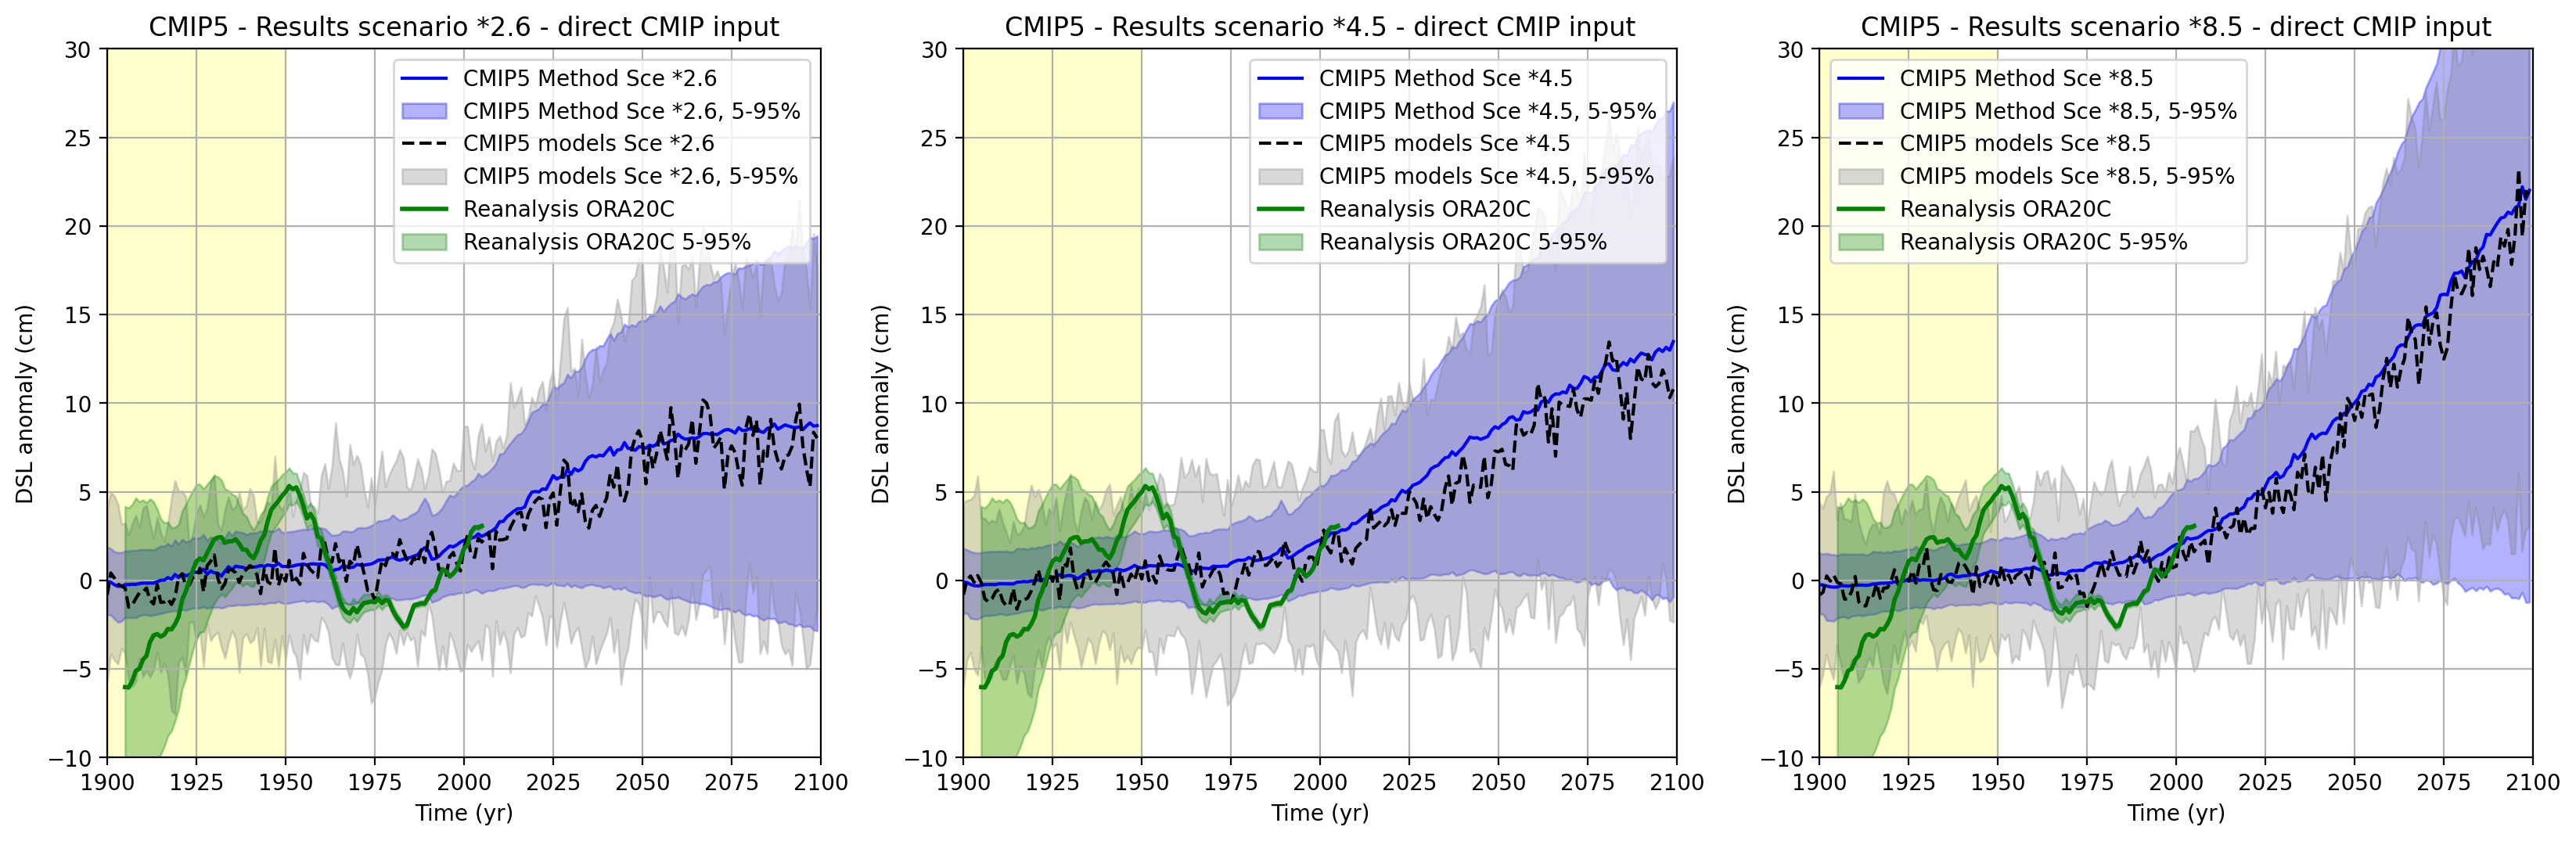

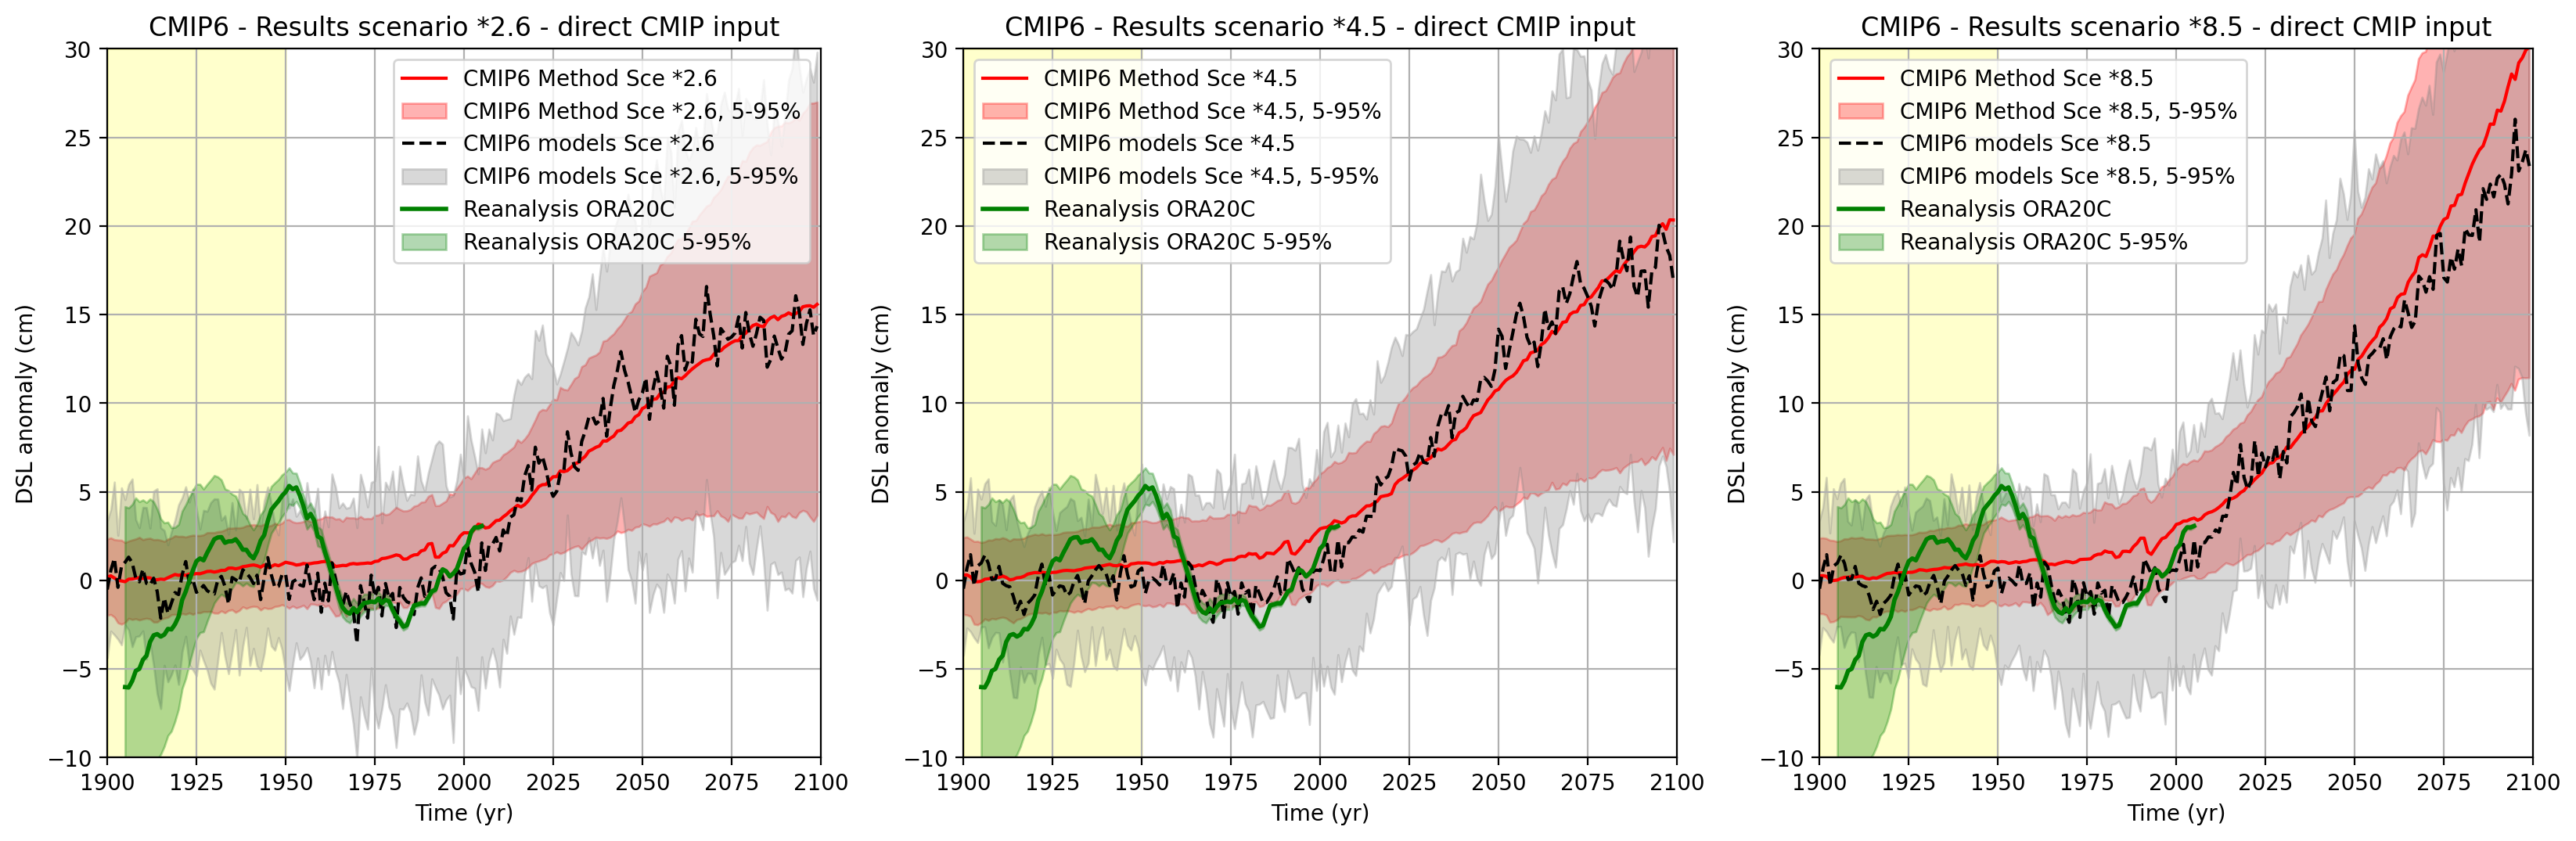

In [122]:
plot_Method2_compare_v2(CMIP5ds, CMIP6ds, CMIP5_DSLs_n_ext, CMIP6_DSLs_n_ext, 'direct CMIP input')

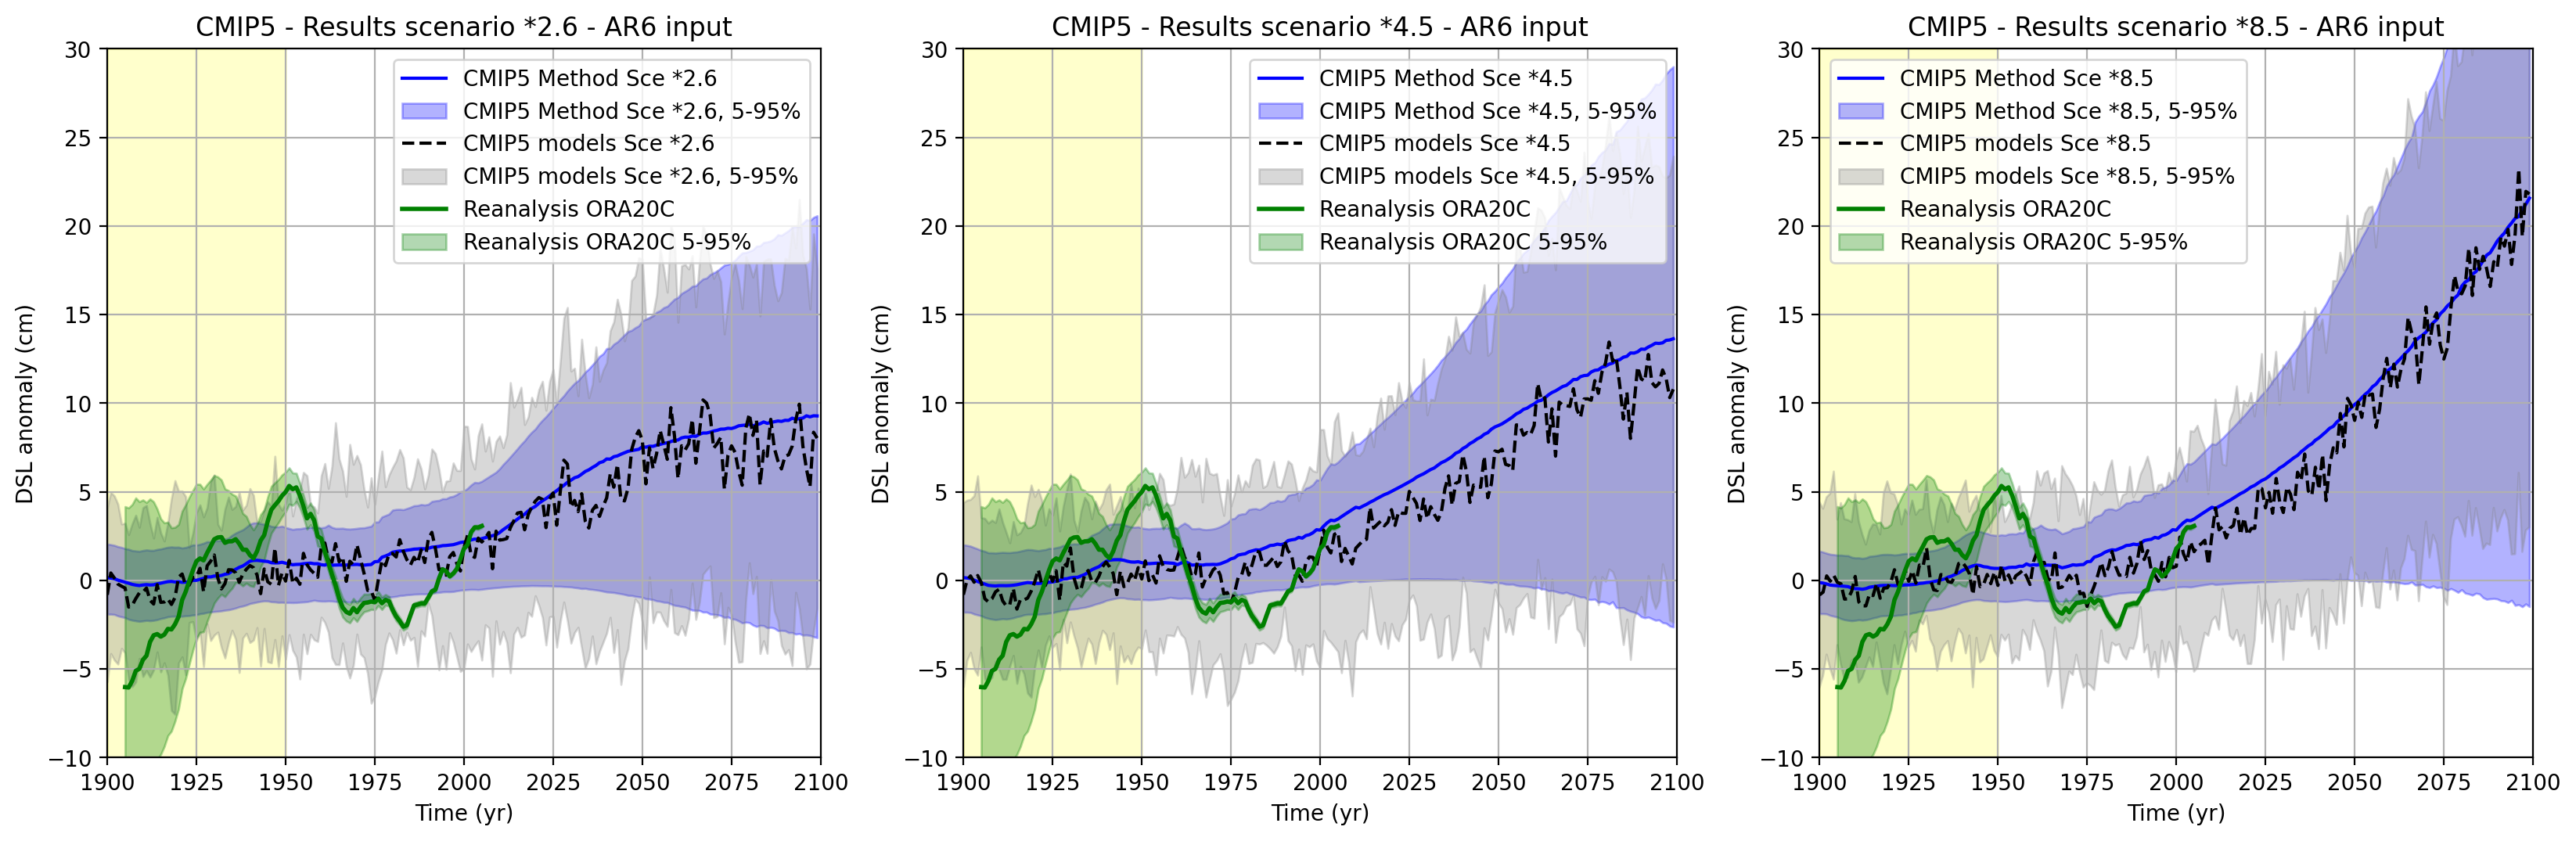

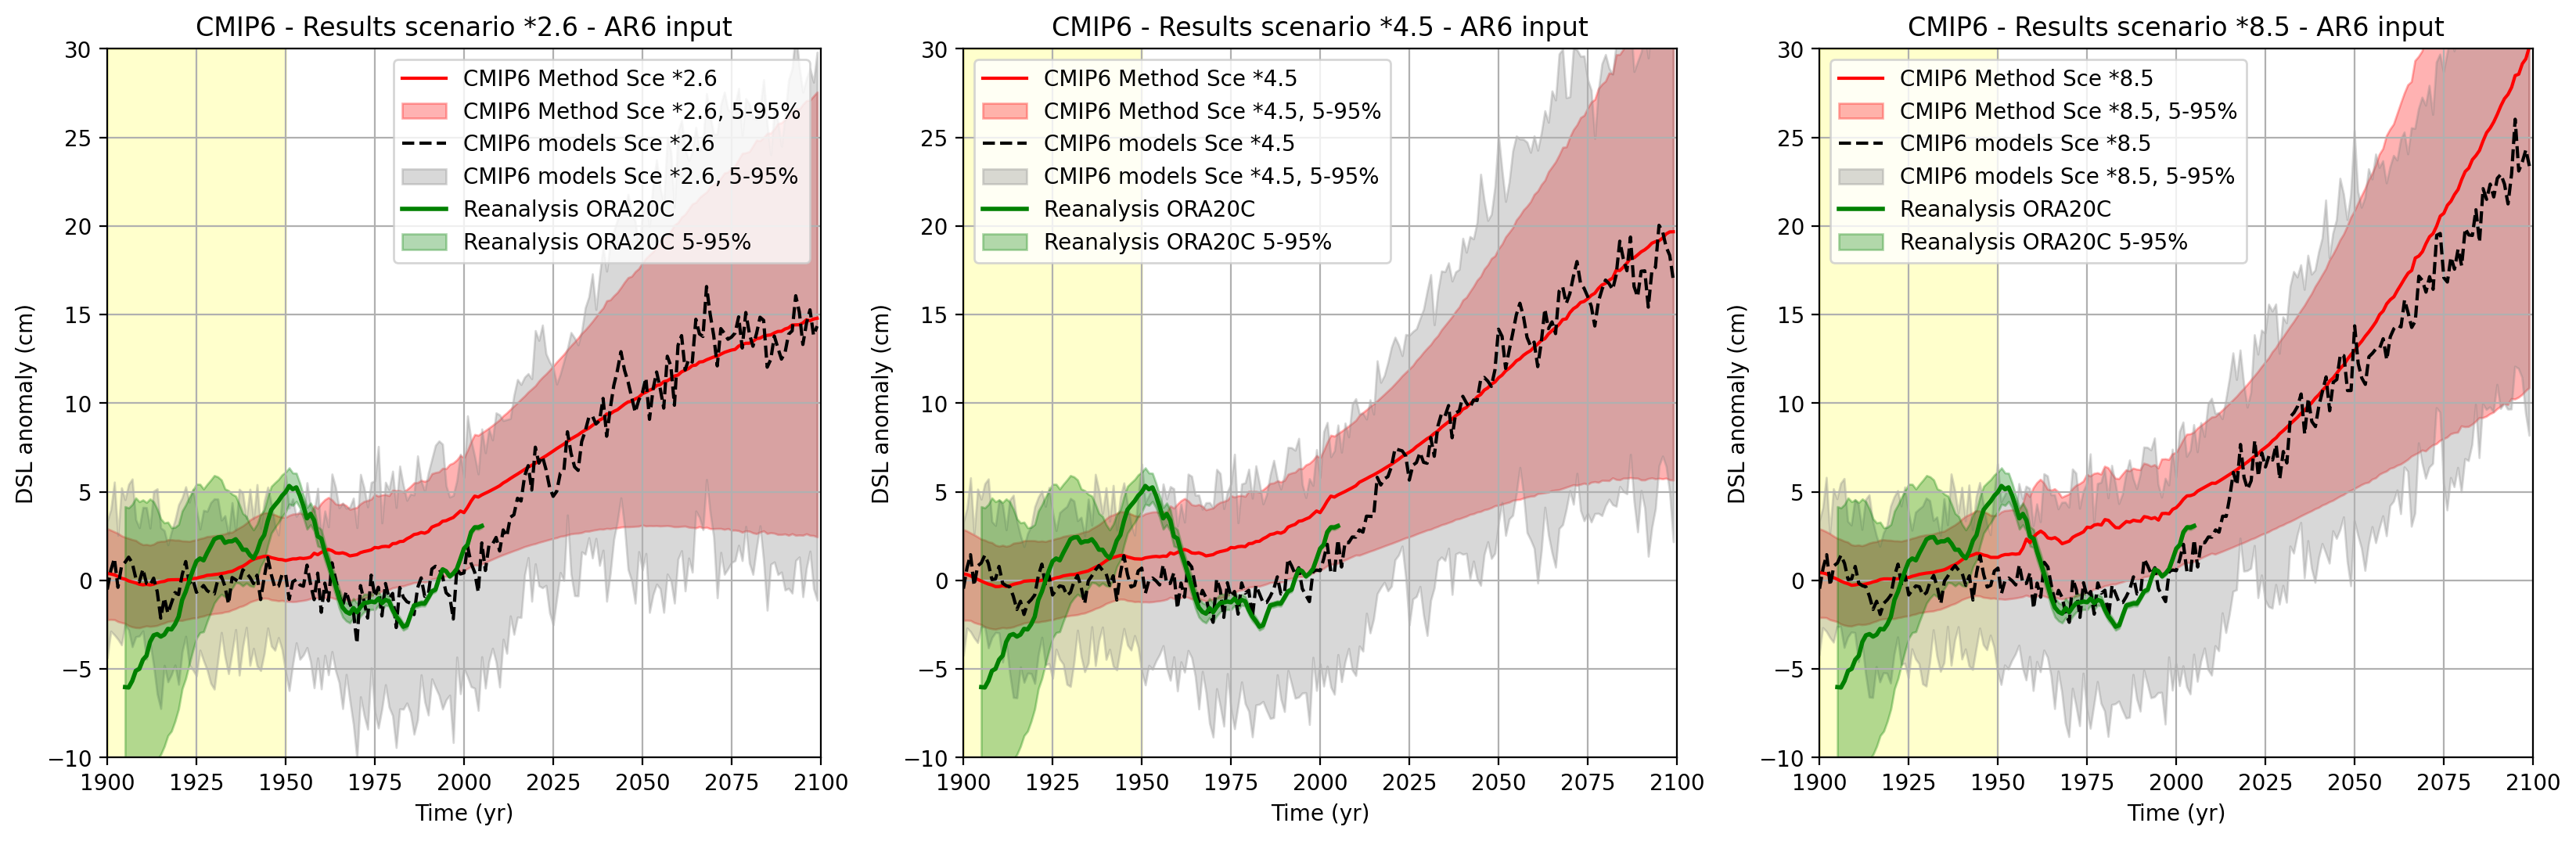

In [123]:
plot_Method2_compare_v2(CMIP5ds, CMIP6ds, CMIP5_DSLs_n_cor, CMIP6_DSLs_n_cor, 'AR6 input')


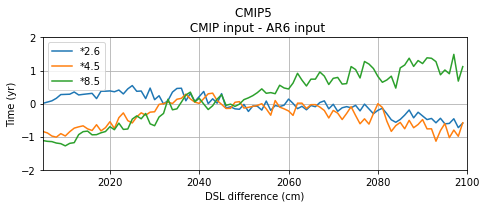

In [37]:
plot_Method2_differences(CMIP5_DSLs_n_ext, CMIP5_DSLs_n_cor, 'none', 'CMIP5')

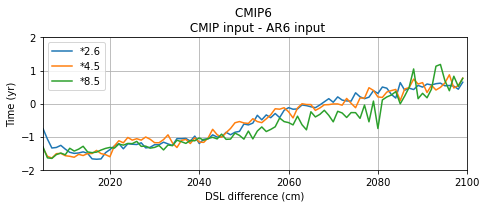

In [38]:
plot_Method2_differences(CMIP6_DSLs_n_ext, CMIP6_DSLs_n_cor, 'none','CMIP6')